# Loading NIfTI images and some simple data manipulation

### Loading juila packages to read nifti data and display images

This cell only needs to run once when you start the kernel & this notebook

In [1]:
push!(LOAD_PATH,"library");
using Read_NIfTI1_real
using PyPlot
using NK_tools

INFO: Precompiling module PyPlot.


### Loading NIfTI file

In [2]:
filename = "data/MNI152_T1_2mm_brain.nii.gz";
headerinfo = load_niigz_header(filename); # see the source code in library/Read_NIfTI1_real.jl
data = load_niigz_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl
println("data size : ", size(data))
print("type of data: ", typeof(data))

data size : (91, 109, 91)
type of data: Array{Int16,3}

### Optionally changing the orientation of images

In [3]:
data = flipdim(permutedims(data,[2,1,3]),1);

### Displaying a single slice (e.g., slice # 45)

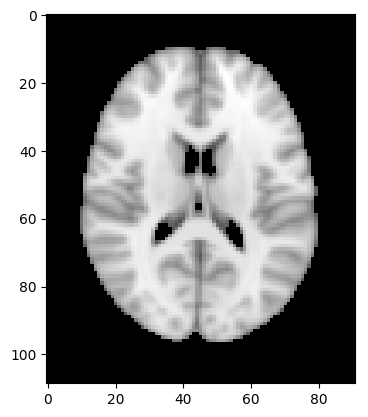

In [4]:
imshow(data[:,:,45],cmap="gray", interpolation="none"); # part of PyPlot

### Displaying multiple selected slices in 8 x 6 subplots

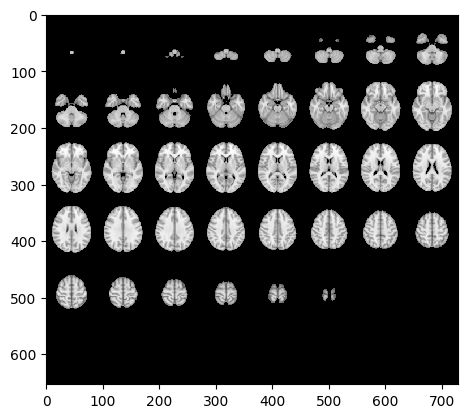

952224

In [5]:
imal(data[:,:,2:2:end],8,6); # see the source codes in library/NK_tools.jl

###  Converting data to double float format for further analysis

In [6]:
dataDouble = convert(Array{Float64},data);
println("type of data: ", typeof(dataDouble))

type of data: Array{Float64,3}


### Converting imaging data to k-space data

type of data :Array{Complex{Float64},3}
3808896

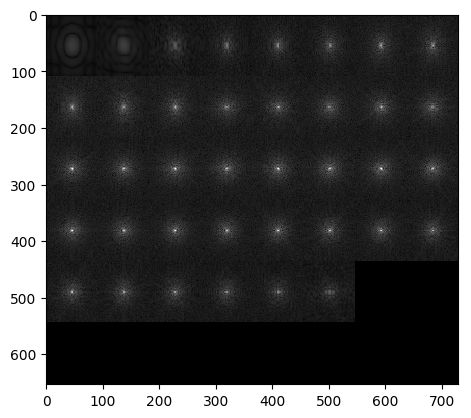

In [7]:
kSpaceData = qift(dataDouble); # 2D IFT: see library/NK_tools.jl
println("type of data :", typeof(kSpaceData));
imal(abs.(kSpaceData[:,:,2:2:end]).^0.3,8,6);

### Creating Hann filter

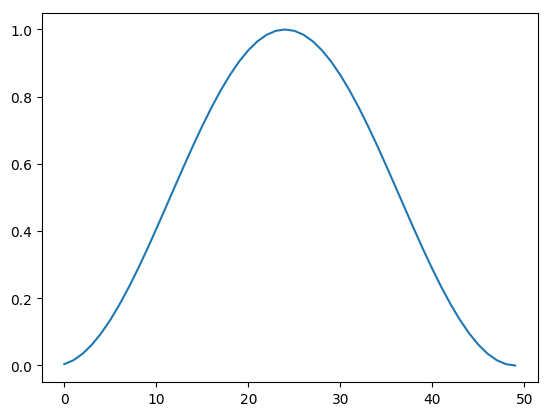

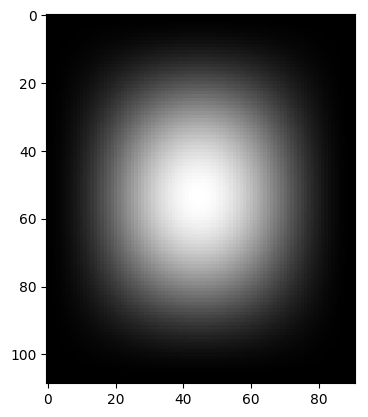

PyObject <matplotlib.image.AxesImage object at 0x7f33268e8f90>

In [8]:
hann(x) =  0.5 * (1 - cos.(2π*(1:x)/x)); # it is easy to define a new function in julia
figure(1); plot(hann(50))
hann2d = hann(size(data)[1])*hann(size(data)[2])';
figure(2); imshow(hann2d,cmap="gray")

### Suppressing high k-space data

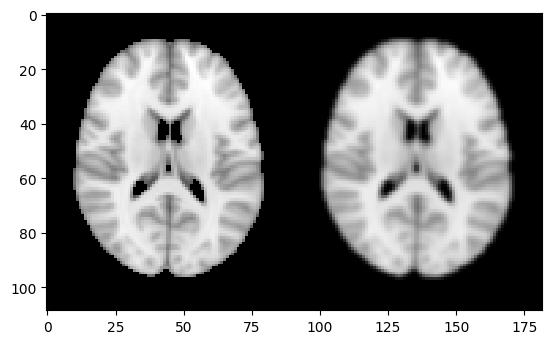

PyObject <matplotlib.image.AxesImage object at 0x7f331d1598d0>

In [9]:
k2d = kSpaceData[:,:,div(size(kSpaceData)[3],2)];
k2d_lowPassFiltered = k2d.*hann2d;
image2d_original = qft(k2d);
image2d_lowPassFiltered = qft(k2d_lowPassFiltered);
imshow(hcat(abs.(image2d_original), abs.(image2d_lowPassFiltered)),cmap="gray", interpolation = "none")

### Smoothing all the slices

In [10]:
xsize,ysize,zsize = size(data)
smoothedImages = zeros(xsize,ysize,zsize);
for cnt = 1:zsize
    k2d = kSpaceData[:,:,cnt];
    k2d_lowPassFiltered = k2d.*hann2d;
    image2d_lowPassFiltered = qft(k2d_lowPassFiltered);
    smoothedImages[:,:,cnt] = abs.(image2d_lowPassFiltered);
end


### Saving smoothed images to a new DICOM file

In [11]:
smoothedImages = 32000. * smoothedImages / maximum(smoothedImages[:]);
headerinfo["cal_max"] = Float32(32000);
headerinfo["cal_min"] = Float32(minimum(smoothedImages[:]));
smoothedImages = permutedims(flipdim(smoothedImages,1),[2,1,3]);
smoothedImages = convert(Array{Int16}, round.(smoothedImages));
newFileName = "data/images_smoothed.nii"
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, smoothedImages);
close(fid);

### Challenge:  Implement a procedure that suppresses low-k-space data